# Brief analysis of the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import json
import ast
import requests
import os

## Importing data

In [2]:
# Import movies dataset
movie_metadata = pd.read_csv('dataset/MovieSummaries/movie.metadata.tsv', sep='\t', header=None , 
names=['WikiID', 'FreebaseID', 'Name', 'Release', 'BoxRevenue', 'Runtime', 'Languages', 'Countries', 'Genres'])
movie_metadata.head()

,WikiID,FreebaseID,Name,Release,BoxRevenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [3]:
# Preprocessing dataset: convert dates to datetime, countries, genres and languages to string

movie_metadata["Release"] = movie_metadata["Release"].apply(lambda x: pd.to_datetime(x, errors = 'coerce')).apply(lambda x: x.strftime('%Y') if pd.notnull(x) else x)
movie_metadata["Countries"] = movie_metadata["Countries"].apply(lambda x: list(ast.literal_eval(x).values()) if pd.notnull(x) else x)
movie_metadata["Languages"] = movie_metadata["Languages"].apply(lambda x: list(ast.literal_eval(x).values()) if pd.notnull(x) else x)
movie_metadata["Genres"] = movie_metadata["Genres"].apply(lambda x: list(ast.literal_eval(x).values()) if pd.notnull(x) else x)
movie_metadata = movie_metadata.dropna(subset=["Release", "Countries", "Genres"])

movie_metadata.head()

,WikiID,FreebaseID,Name,Release,BoxRevenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]


The following characteristics can be observed in the imported data set

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)


## Primary analysis

This is an initial analysis of the dataset.

**Movies country of origin**

We looked at movies' countries of origin. While doing so, we observed that most of the given movies come from the United States of America. This is a piece of important information for future analysis.
In fact, when studying characters' representation, we will know that it mostly comes from characters in US movies. It would be significant to analyze sex and ethnicity representation for each country individually.
Moreover, we looked at the time evolution of countries of origin. This analysis showed an increase in movies from the US  and United Kingdom. This time evolution could be compared to the representation evolution.



In [4]:
# Explode countries for visualization
processed = movie_metadata
processed = processed.explode(column="Countries").reset_index(drop = True)
processed["Release"] = processed["Release"].astype(float)
processed.head()

,WikiID,FreebaseID,Name,Release,BoxRevenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,[English Language],United States of America,"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988.0,NaN,83.0,[Norwegian Language],Norway,"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987.0,NaN,110.0,[English Language],United Kingdom,"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983.0,NaN,106.0,[German Language],Germany,[Drama]


Countries
United States of America    33197
India                        7764
United Kingdom               7452
France                       4199
Italy                        3017
Name: Release, dtype: int64


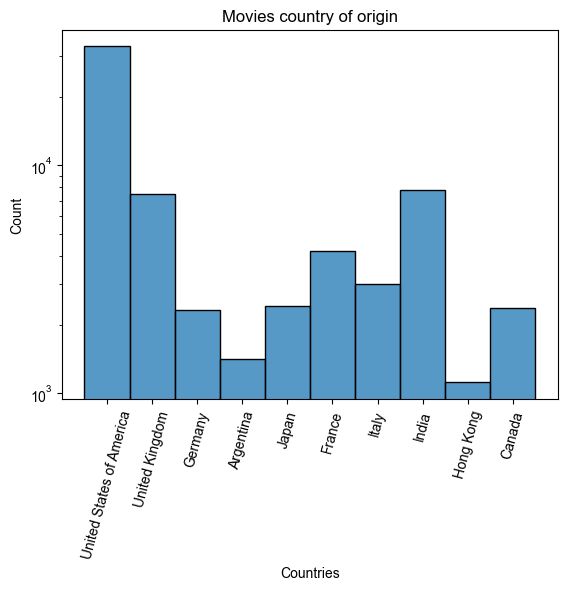

In [5]:
# Plot histogram of the countries with the most productions
sns.histplot(data=processed[processed["Countries"].isin(processed.groupby(by="Countries")["Name"].count().nlargest(10).index)], x="Countries",log_scale=(False,True))
plt.xticks(rotation=75)
plt.title('Movies country of origin')
sns.set(rc={'figure.figsize':(10,10)})
sns.set_style("darkgrid")
processed = processed[processed["Countries"].isin(processed.groupby(by="Countries")["Name"].count().nlargest(5).index)]

print(processed.groupby(by="Countries")["Release"].count().sort_values(ascending=False))

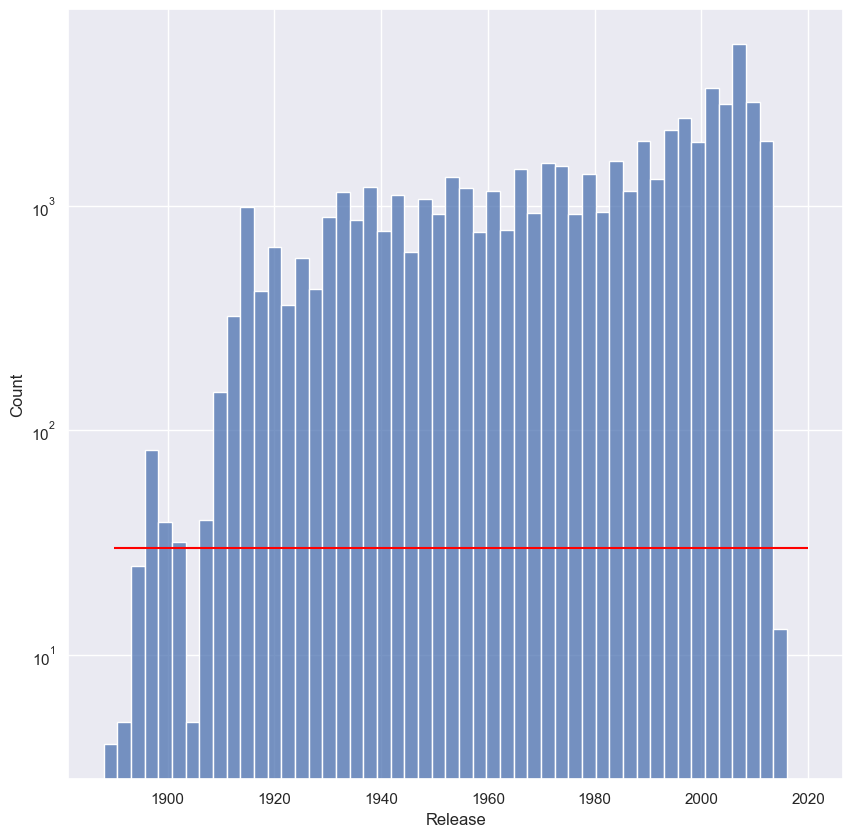

In [6]:
sns.histplot(data=processed, x="Release", log_scale=(False,True))
plt.hlines(30, xmin=1890, xmax=2020, colors='red')

In [7]:
processed = processed[processed["Release"].apply(lambda x: 1913<x<2013)]

**Box Revenue**

Additionally, we studied the box revenue of each movie based on the movie genres from the United States and the United Kingdom, as they represent most of the given movies. Movies with the most significant revenue are linked to epic genres around 2009. After 2009, Superhero movies dominate in the United States.
It would be interesting to look at representation in this genre to see if representation is linked to higher or lower revenue. However, there is a limitation. We only have access to the box office, and thus we weren't able to compare it to the movie investment.

When we looked at global box revenue, we observed the epic genre to have the highest box revenue around the same time (2009). After 2009, we don't have genres that stand out.

## Characters' representation

In [17]:
# Import characters dataset and preprocessing
characters = pd.read_csv('dataset/MovieSummaries/character.metadata.tsv', sep='\t', header=None, 
names = ["WikiID", "FreebaseID", "Release", "Character name", "Birth", 
"Gender", "Height (m)", "Ethnicity", "Name", "Age at movie release",
"Freebase character/actor map ID", "Freebase character ID", "Freebase actor ID"])
characters = characters.dropna(subset=["Release", "Gender", "Ethnicity","Age at movie release"])
characters["Release"] = characters["Release"].apply(lambda x: pd.to_datetime(x, errors = 'coerce').year if pd.notnull(x) else x)
characters["Birth"] = characters["Birth"].apply(lambda x: pd.to_datetime(x, errors = 'coerce').year if pd.notnull(x) else x)
characters.head()
# We will go from 450'000 to 93'000 rows by droping the ones containing NA values

,WikiID,FreebaseID,Release,Character name,Birth,Gender,Height (m),Ethnicity,Name,Age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
1,975900,/m/03vyhn,2001,Lieutenant Melanie Ballard,1974,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001,Desolation Williams,1969,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
5,975900,/m/03vyhn,2001,Commander Helena Braddock,1949,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
11,975900,/m/03vyhn,2001,Tres,1959,M,NaN,/m/064b9n,Rodney A. Grant,42.0,/m/0bgchrs,/m/0bgchrw,/m/03ydsb
27,3196793,/m/08yl5d,2000,NaN,1937,M,NaN,/m/0x67,Albert Hall,62.0,/m/0lr37dy,NaN,/m/01lntp


**Ethnicities**

At first, we had to match FreebaseIDs to comprehensible ethnicities. After doing so, we looked at ethnicity representation across time in movies from top-producing countries. We can see that one ethnicity seems to be very present throughout time. In fact, Indian ethnicity is very present, especially around 2005.  This seemed odd at first since we have previously seen that most movies come from the United States. However, this may be because movies from India list more main characters than other movies. Thus, we decided to look at ethnicity representation throughout time per country. In our graph representing ethnicities in movies from the United States, we see a different representation. It is, therefore, necessary to normalize our data of ethnicities per movie to avoid false assumptions due to different numbers of characters per movie for example.

Then we decided to look at age distribution in function of ethnicities and time. We discovered that most all ethnicities have similar age distributions. Additionally, we wanted to look at age distribution in function of ethnicity and sex. The main observation here was the clear distinction between the male and female actors' age. Moreover, we can see that Indian actresses are much younger than other actresses. It would be interesting to look into this age difference more precisely in future analysis. Furthermore, we should look into the statistical significance of representation differences. Finally, we could compare ethnic representation to the population of the country of origin.

A limitation we have seen is for movies coming from India. In fact, the written ethnicity of most of the actors is Indian. The dataset doesn't go into precise ethnic groups, which makes the analysis vague for most countries.

In [9]:
# Generate the list of different ethnicities
ethnicities = characters['Ethnicity'].dropna().unique().tolist()

In [24]:
if os.path.isfile("data/characters"):
    characters = pd.read_pickle("data/characters")
else:
    # Function which allows query search of ids using Wikidata SPARQL service
    def get_ethnicities(ids):

        tmp = '""'.join(ids)

        url = 'https://query.wikidata.org/sparql'
        query = '''
        SELECT  ?ethnicities ?sLabel WHERE {
        VALUES ?ethnicities {"'''+tmp+'''"} 
        ?s wdt:P646 ?ethnicities .

            SERVICE wikibase:label {
            bd:serviceParam wikibase:language "en" .
            }
        }
        '''
        r = requests.post(url, params = {'format': 'json', 'query': query})
        data = r.json()
        return data
    d1 = get_ethnicities(ethnicities[1:200])
    d2 = get_ethnicities(ethnicities[201:478])
    tmp1 = []
    tmp2 = []
    for d in (d1, d2):
        for el in d["results"]["bindings"]:
            tmp1.append(el["ethnicities"]["value"])
            tmp2.append(el["sLabel"]["value"])
    table_eth = pd.DataFrame(tmp1, tmp2).reset_index().rename(columns = {"index": "Ethnicities", 0: "code"})
    # Table associating the freebase id with the ethnicities


    """Code for querying using Google's knowledge graph"""
    import json
    import urllib
    # We are only going to use the Google's KG for the remaining codes that we couldn't find in WikiData 
    ids = list(set(ethnicities) - set(table_eth["code"]))
    # Private api key for using Google's API
    if os.path.isfile("api_key.txt"):
        api_key = open("api_key.txt").read()
        service_url = 'https://kgsearch.googleapis.com/v1/entities:search'
        params = {
            'limit': 500,
            'indent': True,
            'key': api_key,
        }
        url = service_url + '?' + 'ids='+'&ids='.join(ids).replace("/", "%2F" )+'&'+urllib.parse.urlencode(params)
        response = json.loads(urllib.request.urlopen(url).read())
        for element in response['itemListElement']:
            print(element['result']['name'] + ' (' + str(element['result']["@id"]) + ')')
        tmp1 = []
        tmp2 = []
        for element in response['itemListElement']:
            tmp2.append(element['result']['name'])
            tmp1.append(element['result']["@id"].replace("kg:", ''))
        table_eth = pd.concat([table_eth, pd.DataFrame(tmp1, tmp2).reset_index().rename(columns = {"index": "Ethnicities", 0: "code"})])
 

    # Replace ethnicity code by value
    characters["Ethnicity"] = characters["Ethnicity"].apply(lambda x: table_eth["Ethnicities"][table_eth["code"]==x].values[0]
    if any(table_eth["code"]==x) else x)
    characters.to_pickle("data/characters")
characters.head()

Asante people (kg:/m/01flqq)
Samoan New Zealanders (kg:/m/0404kdr)


,WikiID,FreebaseID,Release,Character name,Birth,Gender,Height (m),Ethnicity,Name,Age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
1,975900,/m/03vyhn,2001,Lieutenant Melanie Ballard,1974,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001,Desolation Williams,1969,M,1.727,African Americans,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
5,975900,/m/03vyhn,2001,Commander Helena Braddock,1949,F,1.727,African Americans,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
11,975900,/m/03vyhn,2001,Tres,1959,M,NaN,Omaha people,Rodney A. Grant,42.0,/m/0bgchrs,/m/0bgchrw,/m/03ydsb
27,3196793,/m/08yl5d,2000,NaN,1937,M,NaN,African Americans,Albert Hall,62.0,/m/0lr37dy,NaN,/m/01lntp


In [25]:
# Find character which appear in the movies made by the top producing countries
charac_group = processed.groupby(by="Countries", as_index=True).apply(lambda x: 
pd.merge(characters[["WikiID", "Release", "Gender", "Ethnicity","Age at movie release", "Birth"]][characters["WikiID"].isin(x["WikiID"])], x[["Genres","WikiID"]], on=["WikiID"]))
charac_group.head()

WikiID  Release Gender   Ethnicity  Age at movie release  \
Countries                                                                 
France    0  13944412     2007      M      French                  41.0   
          1  13944412     2007      F      French                  69.0   
          2   1031231     1998      F  /m/04kbvpz                  28.0   
          3  22256486     1995      F      French                  51.0   
          4  22256486     1995      M    Italians                  70.0   

             Birth                                             Genres  
Countries                                                              
France    0   1965  [Thriller, Drama, Psychological thriller, Worl...  
          1   1937  [Thriller, Drama, Psychological thriller, Worl...  
          2   1970  [Romantic comedy, Comedy, Music, Comedy of Err...  
          3   1943     [Ensemble Film, Romance Film, Comedy, History]  
          4   1924     [Ensemble Film, Romance Film, Comedy, History]

C:\Users\nico9\AppData\Local\Temp\ipykernel_18920\3974653000.py:10: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  tmp = tmp.groupby(by="Release").apply(count_eth)


Text(0.5, 1.0, 'Ethnic representation in the World across time')

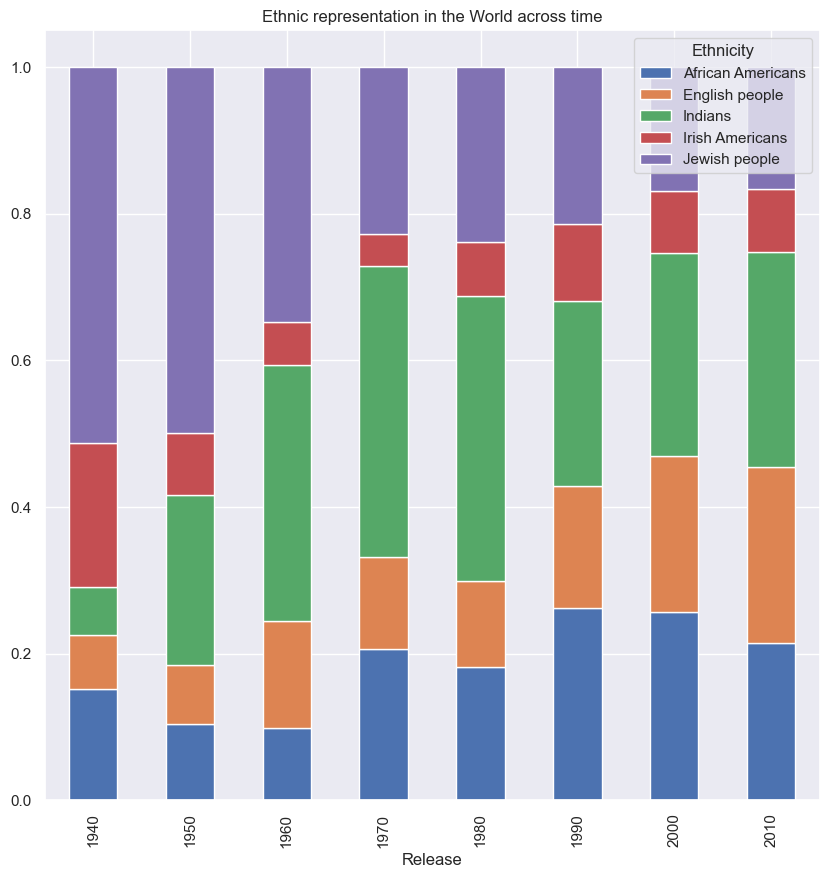

In [32]:
# Generate plot of people of different ethnicities vs the date of release
tmp = charac_group.reset_index().drop(columns="level_1")
tmp = tmp[tmp["Ethnicity"].isin(tmp["Ethnicity"].value_counts().nlargest(5).index)]
tmp = tmp[tmp["Release"].apply(lambda x: x>1940)]

tmp=tmp.groupby(by=["Ethnicity", "Release"]).count().reset_index().rename(columns = {"Countries": "Count"})
def count_eth(x): 
    x["Count"] = x["Count"]/x["Count"].sum()
    return x
tmp = tmp.groupby(by="Release").apply(count_eth)


tmp = tmp.pivot_table(index = 'Release', columns='Ethnicity', values='Count', aggfunc='mean', fill_value=0)
tmp = tmp.groupby((tmp.index//10)*10).mean()
tmp.plot(kind = 'bar', stacked = True)
plt.title('Ethnic representation in the World across time')

C:\Users\nico9\AppData\Local\Temp\ipykernel_18920\1622089801.py:11: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  tmp = tmp.groupby(by="Release").apply(count_eth)


Text(0.5, 1.0, 'Ethnic representation in US movies across time')

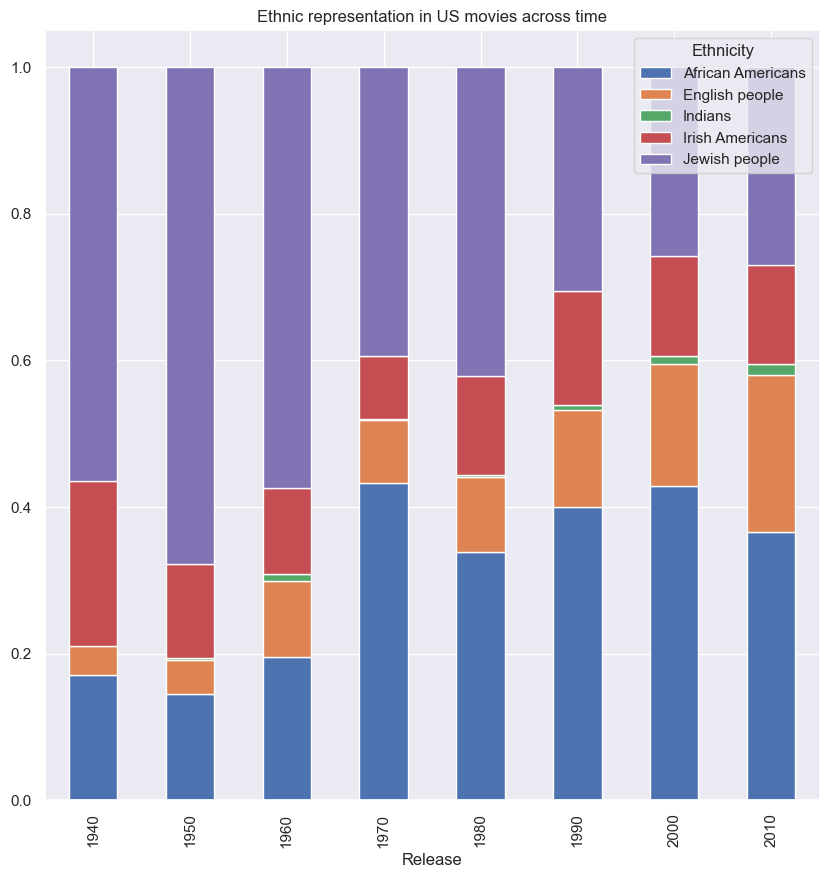

In [31]:
# Generate plot of people of different ethnicities vs the date of release
tmp = charac_group.reset_index().drop(columns="level_1")
tmp = tmp[tmp["Ethnicity"].isin(tmp["Ethnicity"].value_counts().nlargest(5).index)]
tmp = tmp[tmp["Release"].apply(lambda x: x>1940)]
tmp  = tmp[tmp["Countries"]=="United States of America"]

tmp=tmp.groupby(by=["Ethnicity", "Release"]).count().reset_index().rename(columns = {"Countries": "Count"})
def count_eth(x): 
    x["Count"] = x["Count"]/x["Count"].sum()
    return x
tmp = tmp.groupby(by="Release").apply(count_eth)


tmp = tmp.pivot_table(index = 'Release', columns='Ethnicity', values='Count', aggfunc='mean', fill_value=0)
tmp = tmp.groupby((tmp.index//10)*10).mean()
tmp.plot(kind = 'bar', stacked = True)
plt.title('Ethnic representation in US movies across time')

C:\Users\nico9\AppData\Local\Temp\ipykernel_18920\2293636906.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = tmp[tmp["Age at movie release"]>0][tmp["Release"]>1940][tmp["Ethnicity"].notna()]


Text(0.5, 1.0, 'Actors age in function of their ethnicities across time')

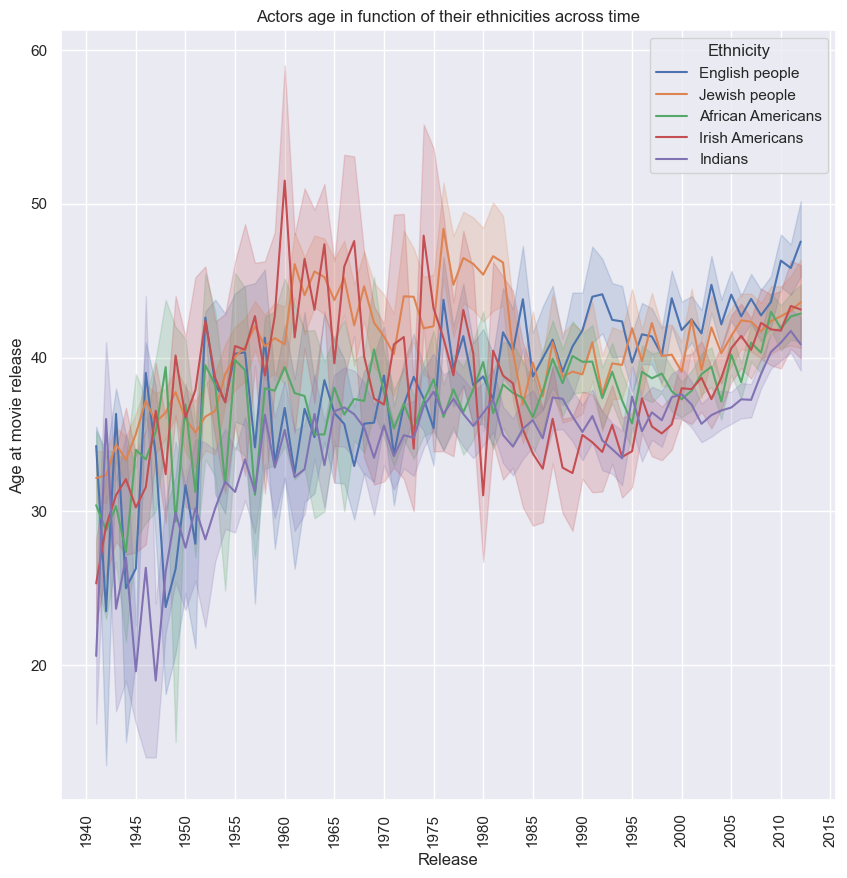

In [33]:
# Generate plot of age of people of different ethnicities vs the date of release
tmp = charac_group.reset_index().drop(columns="level_1")
tmp = tmp[tmp["Release"].notna()]
tmp["Release"] = tmp["Release"].astype(float)
tmp = tmp[tmp["Age at movie release"]>0][tmp["Release"]>1940][tmp["Ethnicity"].notna()]
tmp = tmp[tmp["Ethnicity"].isin(tmp["Ethnicity"].value_counts().nlargest(5).index)]

tmp["Release"] = tmp["Release"].astype(float)
sns.lineplot(data=tmp, x = "Release", y="Age at movie release", hue="Ethnicity")
plt.xticks(rotation=90)
plt.locator_params(axis='x', nbins=20)
plt.title('Actors age in function of their ethnicities across time')

We had to filter all the people whoose age was >0 as the dataset contains aberrant values (negative). Furthermore, we filtered plotted only the data points for which date>1940 as the previous movies also showed an unexpected behaviour

C:\Users\nico9\AppData\Local\Temp\ipykernel_13324\1234497788.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = tmp[tmp["Age at movie release"]>0][tmp["Release"]>1940][tmp["Gender"].notna()]


Text(0.5, 1.0, 'Actors age in function of their nationality and sex across time')

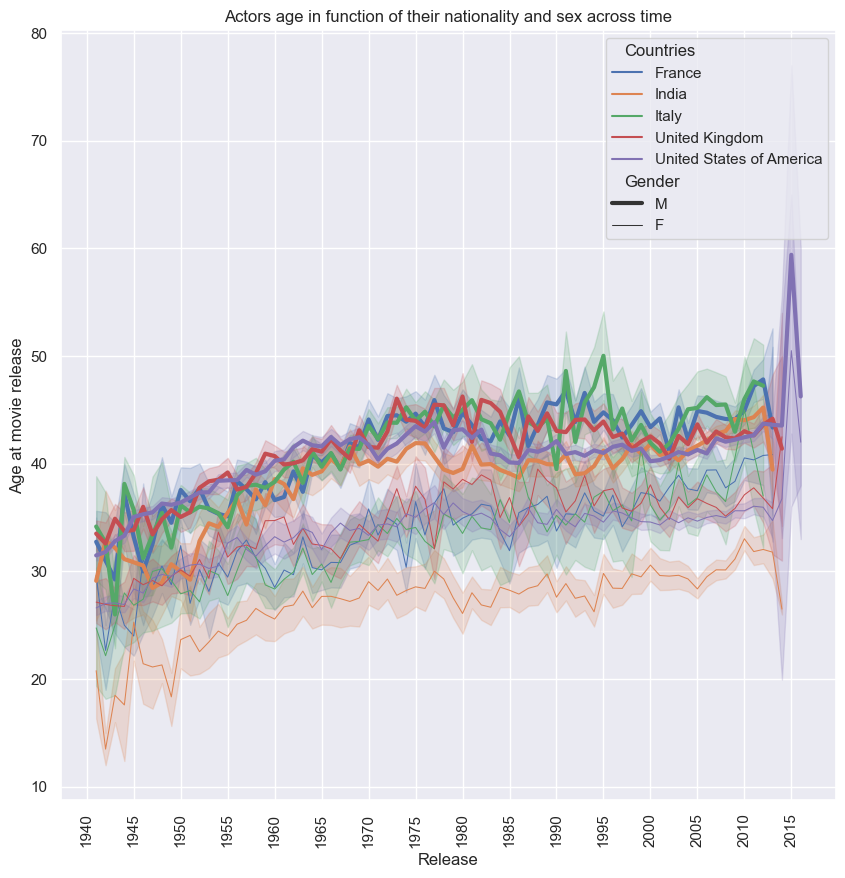

In [ ]:
# Plot of age at movie release vs date of film for different countries/sex
tmp = charac_group.reset_index().drop(columns="level_1")
tmp = tmp[tmp["Release"].notna()]
tmp["Release"] = tmp["Release"].astype(float)
tmp = tmp[tmp["Age at movie release"]>0][tmp["Release"]>1940][tmp["Gender"].notna()]

tmp["Release"] = tmp["Release"].astype(float)
sns.lineplot(data=tmp, x = "Release", y="Age at movie release", hue="Countries", size="Gender")
plt.xticks(rotation=90)
plt.locator_params(axis='x', nbins=20)
plt.title('Actors age in function of their nationality and sex across time')

## New plots

C:\Users\nico9\AppData\Local\Temp\ipykernel_13324\1196427938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["Release"]=tmp["Release"].astype(float)
C:\Users\nico9\AppData\Local\Temp\ipykernel_13324\1196427938.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = tmp[tmp["Release"]>1913][tmp["Release"]<2013]


Text(0, 0.5, 'Percentage character gender')

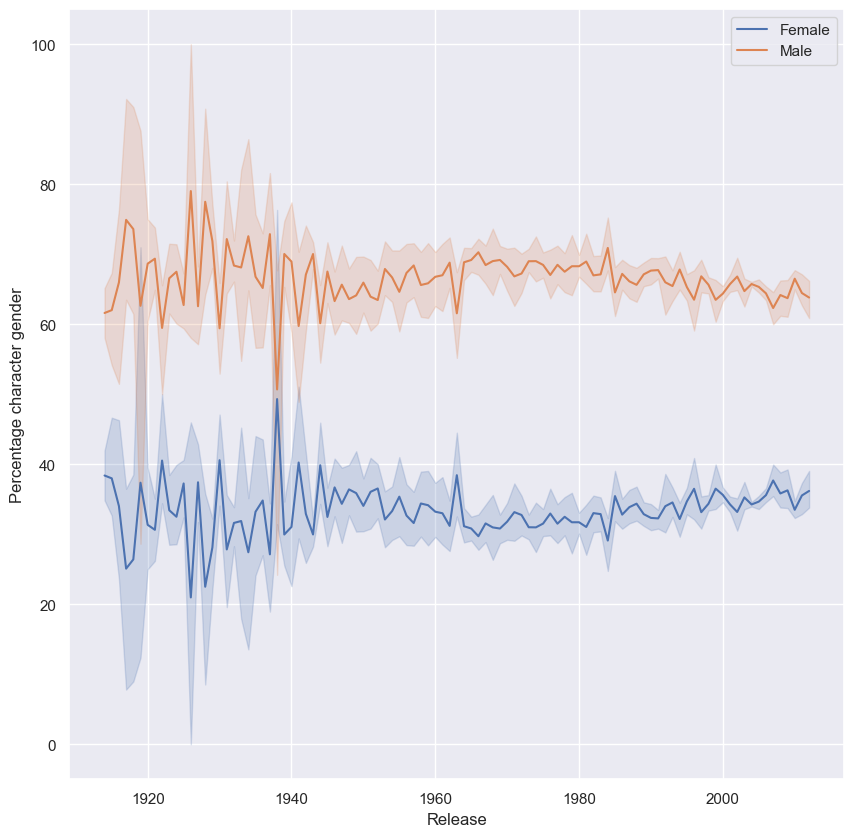

In [ ]:

tmp = charac_group.dropna(subset=["Gender", "Release"])
tmp["Release"]=tmp["Release"].astype(float)
tmp = tmp[tmp["Release"]>1913][tmp["Release"]<2013]

tmp = tmp.groupby(by=["Countries", "Release"]).apply(lambda x: pd.DataFrame({"Female": [(x["Gender"]=="F").sum()/x["Gender"].count()*100],
"Male": [(x["Gender"]=="M").sum()/x["Gender"].count()*100]})).reset_index().drop(columns="level_2")
tmp.head()

sns.lineplot(data=tmp, x="Release", y="Female", label="Female")
sns.lineplot(data=tmp, x="Release", y="Male", label="Male")
plt.ylabel("Percentage character gender")


In [ ]:
# number of films in 2016 and % femmes

In [ ]:
l = pruned.explode("Genres")["Genres"].dropna().unique()
l.sort()
l = [s.lower() for s in l]
matching = [s for s in l if "sex" in s]

In [ ]:
lgbt = ["gay", "gay interest", "gay themed", "lgbt"]
porno = ['gay pornography',
 'hardcore pornography',
 'pornographic movie',
 'pornography',
 'softcore porn']

<AxesSubplot: xlabel='Release', ylabel='Age at movie release'>

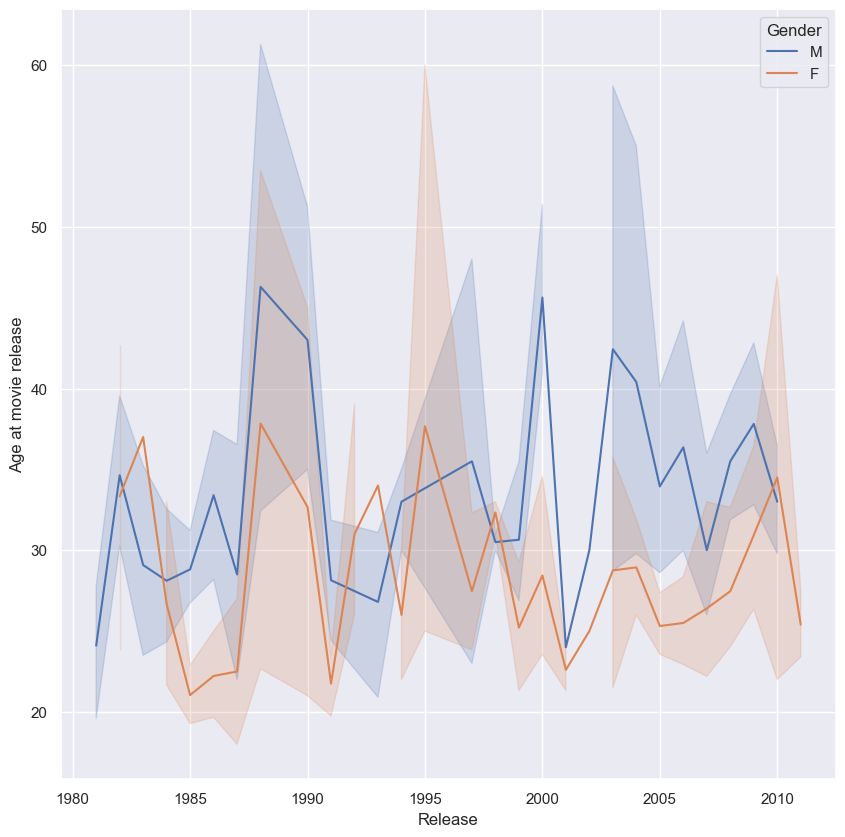

In [ ]:
tmp = charac_group.dropna(subset="Release")
tmp = tmp[tmp["Release"].apply(lambda x: 1980<float(x)<2013)]
tmp = tmp[tmp["Genres"].apply(lambda x: len(set([s.lower() for s in x]).intersection(set(porno))))>0]
tmp["Release"] = tmp["Release"].astype(float)
#tmp.dropna(subset=["Birth", "Gender", "Release"]) # We gain 1000 with respect to age at movie release
sns.lineplot(data=tmp, x = "Release", y="Age at movie release", hue="Gender")

([<matplotlib.axis.XTick at 0x236b9f5e550>,
 [Text(0, 0, '1914'),
  Text(12, 0, '1926'),
  Text(24, 0, '1938'),
  Text(36, 0, '1950'),
  Text(48, 0, '1962'),
  Text(60, 0, '1974'),
  Text(72, 0, '1986'),
  Text(84, 0, '1998'),
  Text(96, 0, '2010')])

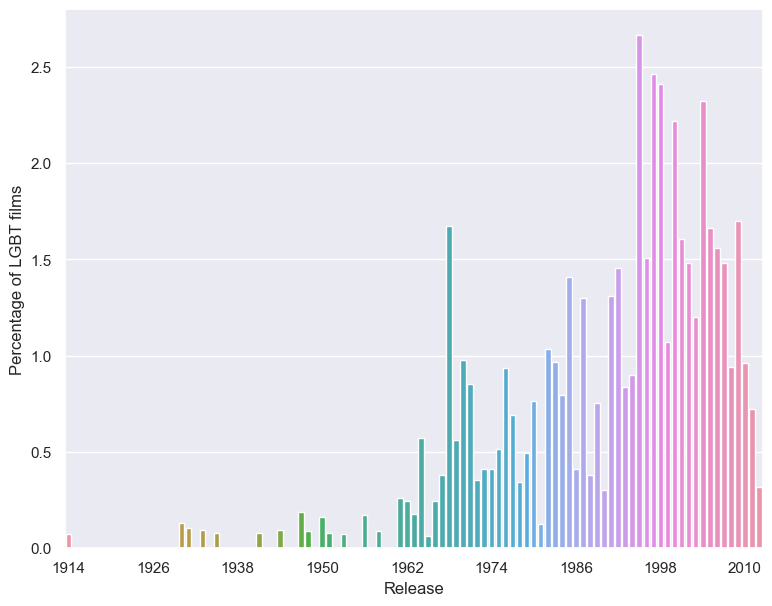

In [ ]:
tmp = pruned.explode("Genres").dropna(subset=["Genres", "Release"])
tmp = tmp[tmp["Release"].apply(lambda x: 1913<float(x)<2013)]
tmp["Genres"] = tmp["Genres"].apply(lambda x: x.lower())
tmp = tmp.groupby("Release").apply(lambda x: pd.DataFrame({"LGBT": [x["Genres"].isin(lgbt).sum()/x["Genres"].count()*100]})).reset_index().drop(columns="level_1")
plt.figure(figsize=(9,7))
sns.barplot(data=tmp, x= "Release", y="LGBT")
plt.ylabel("Percentage of LGBT films")
plt.xticks(np.arange(0, 100 + 1, 12))


Text(0, 0.5, 'Percentage of LGBT films')

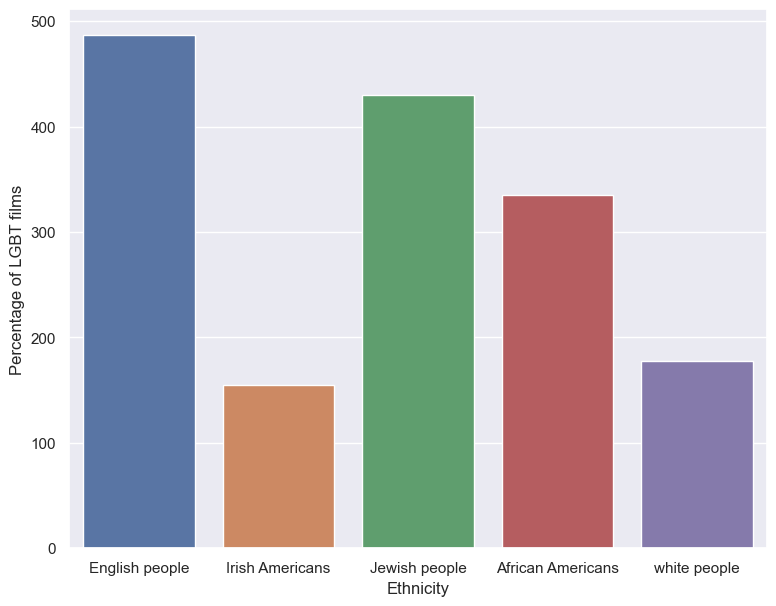

In [ ]:
tmp = charac_group.explode("Genres").dropna(subset=["Genres", "Release"])
tmp = tmp[tmp["Release"].apply(lambda x: 1913<float(x)<2013)]
tmp["Genres"] = tmp["Genres"].apply(lambda x: x.lower())
tmp= tmp[tmp["Genres"].isin(lgbt)]
tmp["Release"] = tmp["Release"].astype(float)
tmp= tmp[tmp["Ethnicity"].isin(tmp["Ethnicity"].value_counts().nlargest(5).index)]
tmp
plt.figure(figsize=(9,7))
sns.barplot(data=tmp, x= "Ethnicity", y = "Age at movie release", estimator=np.count_nonzero)
plt.ylabel("Percentage of LGBT films")
#plt.xticks(np.arange(0, 100 + 1, 12))

# TO DO: check that you are not inflating the actual values

Text(0, 0.5, 'Percentage of LGBT films')

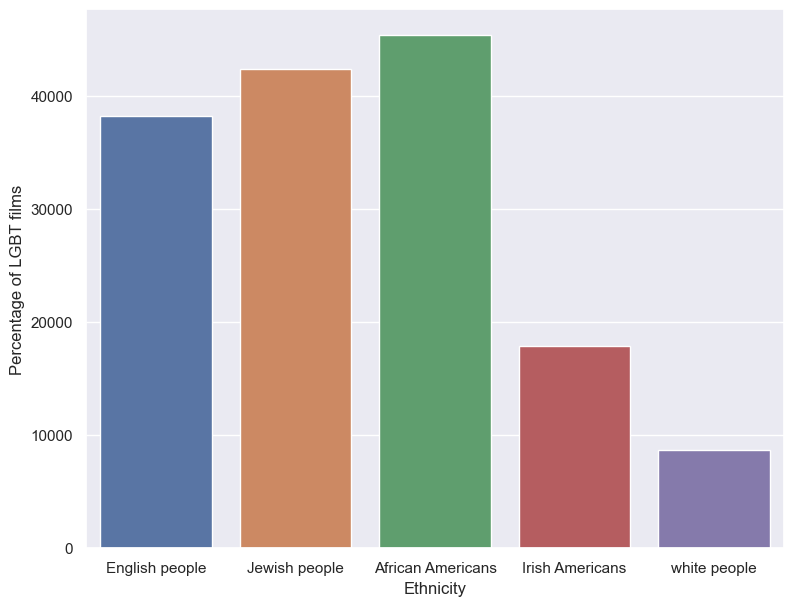

In [ ]:
tmp = charac_group.explode("Genres").dropna(subset=["Genres", "Release"])
tmp = tmp[tmp["Release"].apply(lambda x: 1913<float(x)<2013)]
tmp["Genres"] = tmp["Genres"].apply(lambda x: x.lower())
tmp= tmp[~tmp["Genres"].isin(lgbt)]
tmp["Release"] = tmp["Release"].astype(float)
tmp= tmp[tmp["Ethnicity"].isin(["English people", "Irish Americans","Jewish people", "African Americans", "white people"])]
tmp
plt.figure(figsize=(9,7))
sns.barplot(data=tmp, x= "Ethnicity", y = "Age at movie release", estimator=np.count_nonzero)
plt.ylabel("Percentage of LGBT films")

C:\Users\nico9\AppData\Local\Temp\ipykernel_13324\3363336821.py:6: RuntimeWarning: invalid value encountered in longlong_scalars
  tmp = tmp.groupby(by=["Genres", "Release"]).apply(lambda x: pd.DataFrame({"Female": [(x["Gender"]=="F").sum()/x["Gender"].count()*100],
C:\Users\nico9\AppData\Local\Temp\ipykernel_13324\3363336821.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  "Male": [(x["Gender"]=="M").sum()/x["Gender"].count()*100]})).reset_index().drop(columns="level_2")


<AxesSubplot: xlabel='Release', ylabel='Genres'>

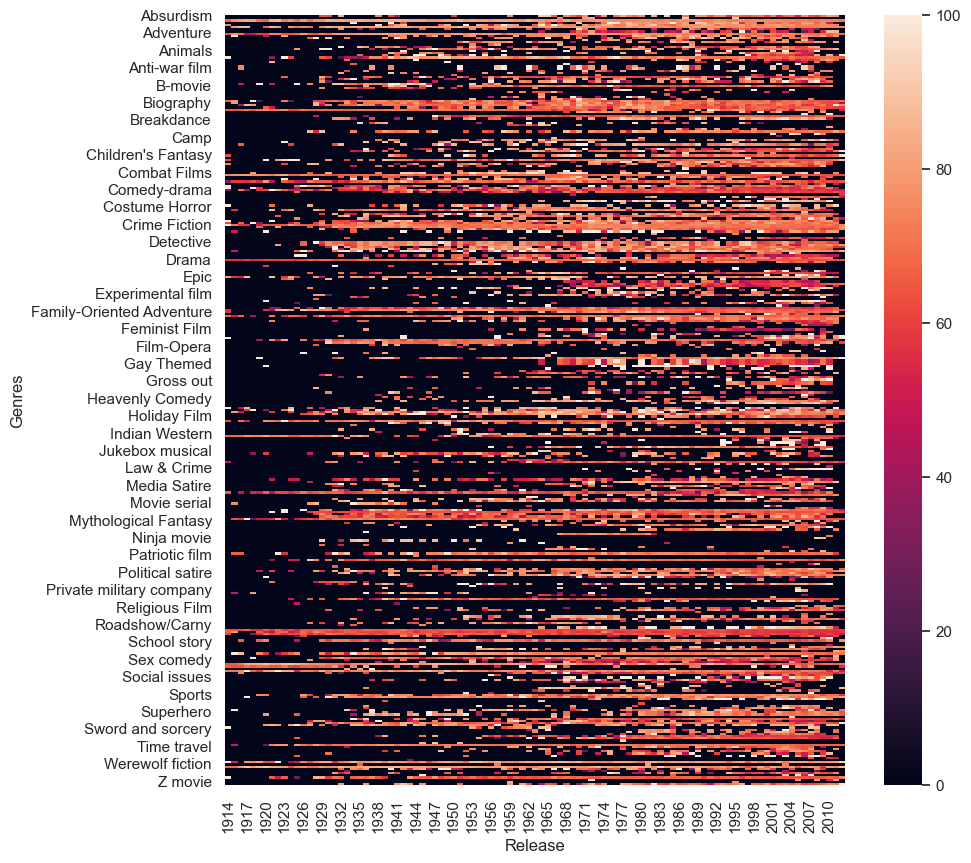

In [ ]:
# BoxRevenue globally
tmp = charac_group.reset_index().dropna(subset="Release")
tmp = tmp[tmp["Release"].apply(lambda x: 1913<float(x)<2013)]
tmp = tmp.explode("Genres")
#tmp = tmp[tmp["Genres"].isin(["Epic", "Comedy", "Sports"])]
tmp = tmp.groupby(by=["Genres", "Release"]).apply(lambda x: pd.DataFrame({"Female": [(x["Gender"]=="F").sum()/x["Gender"].count()*100],
"Male": [(x["Gender"]=="M").sum()/x["Gender"].count()*100]})).reset_index().drop(columns="level_2")
tmp = tmp.pivot_table(index = 'Genres', columns='Release', values='Male', aggfunc='mean', fill_value=0, dropna=False)
# tmp
tmp
# The max value has been fixed at 1.5e9 for better visualization
sns.heatmap(tmp)

<AxesSubplot: xlabel='Release', ylabel='Percentage of female actors'>

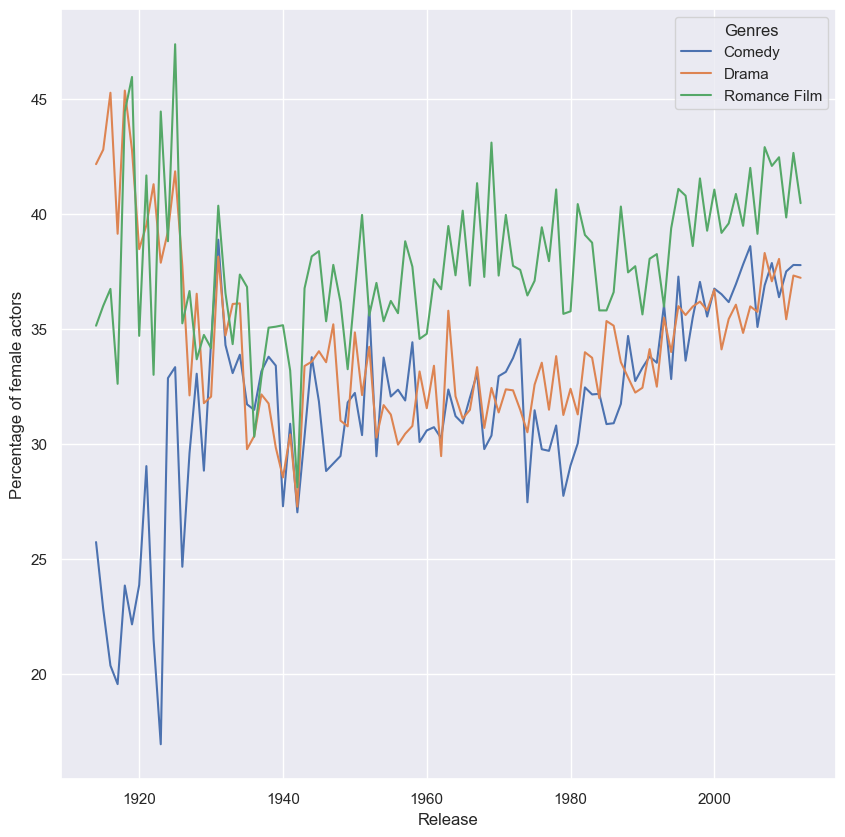

In [ ]:
# BoxRevenue globally

tmp = charac_group.reset_index().dropna(subset="Release")
tmp = tmp[tmp["Release"].apply(lambda x: 1913<float(x)<2013)]
tmp = tmp.explode("Genres")
l = list(tmp.groupby(by="Genres").count().nlargest(3, "Countries").index)

tmp = charac_group.reset_index().dropna(subset="Release").explode("Genres")
tmp["Release"]=tmp["Release"].astype(float)
tmp = tmp[tmp["Release"]>1913]
tmp = tmp[tmp["Release"]<2013]
tmp =tmp[tmp["Genres"].isin(l)]
tmp = tmp.groupby(by=["Genres", "Release"]).apply(lambda x: pd.DataFrame({"Female": [(x["Gender"]=="F").sum()/x["Gender"].count()*100],
"Male": [(x["Gender"]=="M").sum()/x["Gender"].count()*100]})).reset_index().drop(columns="level_2")

# The max value has been fixed at 1.5e9 for better visualization
plt.ylabel("Percentage of female actors")
sns.lineplot(data = tmp, x="Release", y="Female", hue="Genres")

In [ ]:
t = movie_metadata.explode("Genres")
t = t.dropna(subset=["Genres"])
t["Genres"] = t["Genres"].apply(lambda x: x.lower())
t = t[t["Genres"].isin(porno)]
t

,WikiID,FreebaseID,Name,Release,BoxRevenue,Runtime,Languages,Countries,Genres
93,5664529,/m/0dyy_v,Vixen!,1968,NaN,70.0,[English Language],[United States of America],softcore porn
108,24196090,/m/07k8x7p,The World of Geisha,1973,NaN,73.0,[Japanese Language],[Japan],pornographic movie
315,14630761,/m/03gr8yf,Mona the Virgin Nymph,1970,NaN,NaN,[],[United States of America],pornographic movie
645,14710585,/m/03gtyp3,Tanya's Island,1980,NaN,82.0,[English Language],"[United States of America, Canada]",softcore porn
829,23404570,/m/06w2rd_,Sexual Desires in the Ladies' Restroom: Dripping!,1995,NaN,60.0,[Japanese Language],[Japan],pornographic movie
...,...,...,...,...,...,...,...,...,...
81100,19760243,/m/04q7ndk,Candy Goes to Hollywood,NaT,NaN,NaN,[],[],pornographic movie
81148,7092616,/m/0h3sc6,Traci Takes Tokyo,1986,NaN,80.0,[English Language],"[United States of America, Japan]",pornographic movie
81349,15191779,/m/03hlfmf,Women of Fear Factor,2005,NaN,50.0,[English Language],[United States of America],softcore porn
81511,9997901,/m/06_y3mv,Juegos de verano,1973,NaN,NaN,[Spanish Language],[Argentina],pornographic movie


C:\Users\nico9\AppData\Local\Temp\ipykernel_13324\2169917822.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = tmp[tmp["Age at movie release"]>0][tmp["Release"]>1943][tmp["Release"]<2013][tmp["Gender"].notna()]


Text(0.5, 1.0, 'Actors age in function of their nationality and sex across time')

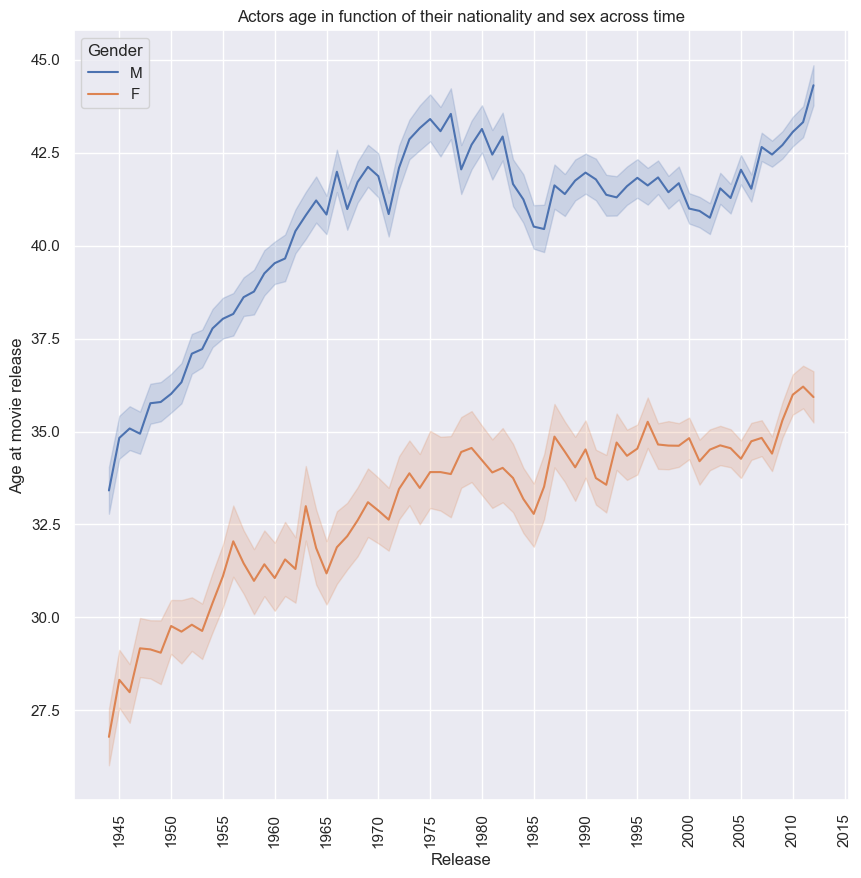

In [ ]:
# Plot of age at movie release vs date of film for different countries/sex
tmp = charac_group.reset_index().drop(columns="level_1")
tmp = tmp[tmp["Release"].notna()]
tmp["Release"] = tmp["Release"].astype(float)
tmp = tmp[tmp["Age at movie release"]>0][tmp["Release"]>1943][tmp["Release"]<2013][tmp["Gender"].notna()]

tmp["Release"] = tmp["Release"].astype(float)
sns.lineplot(data=tmp, x = "Release", y="Age at movie release", hue="Gender")
plt.xticks(rotation=90)
plt.locator_params(axis='x', nbins=20)
plt.title('Actors age in function of their nationality and sex across time')

Text(0.5, 1.0, 'Genre preference of the top five most common ethnicities')

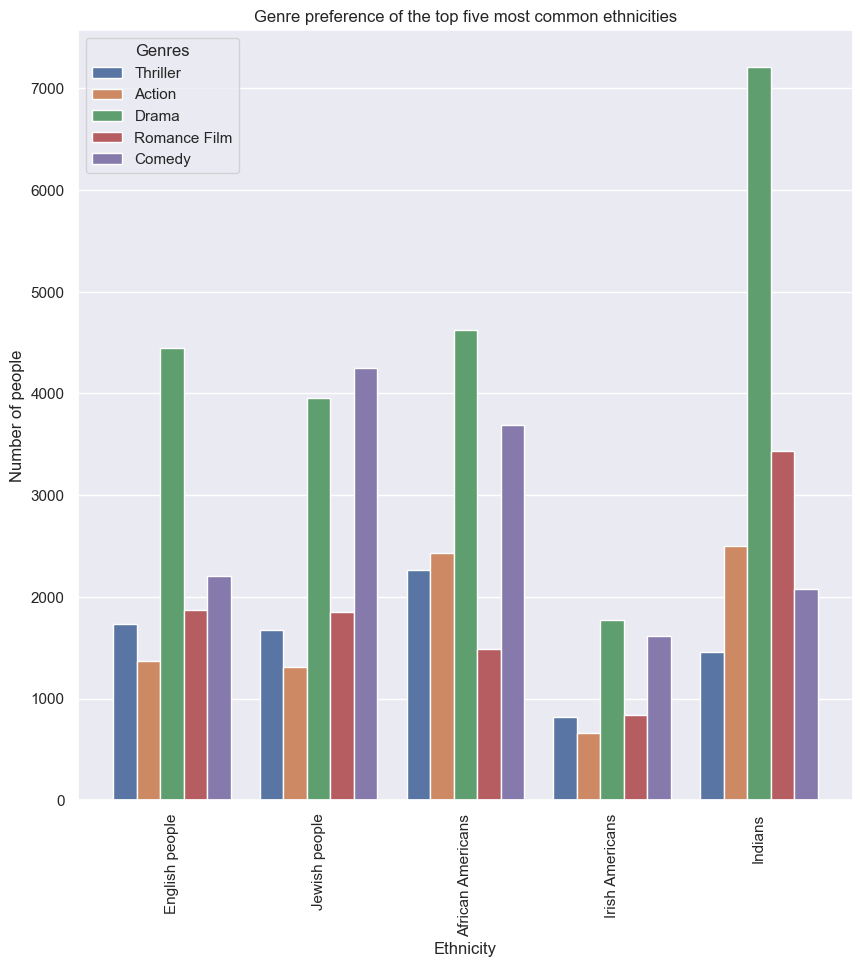

In [ ]:
# Generate plot of age of people of different ethnicities vs the date of release
tmp = charac_group.reset_index().drop(columns="level_1")
tmp = tmp.explode(column="Genres")
tmp = tmp.dropna(subset=["Release", "Ethnicity", "Genres"])
tmp["Release"] = tmp["Release"].astype(float)
tmp = tmp[tmp["Age at movie release"]>0]
tmp = tmp[tmp["Release"]>1940]

tmp = tmp[tmp["Ethnicity"].isin(tmp["Ethnicity"].value_counts().nlargest(5).index)]
tmp = tmp[tmp["Genres"].isin(tmp["Genres"].value_counts().nlargest(5).index)]
tmp["Release"] = tmp["Release"].astype(float)
tmp = tmp.groupby(by=["Ethnicity", "Genres"]).count().groupby(by="Ethnicity").apply(lambda x: )
sns.barplot(data=tmp, x = "Ethnicity", y="Age at movie release", hue="Genres", estimator=np.count_nonzero)
plt.xticks(rotation=90)
plt.locator_params(axis='x', nbins=20)
plt.ylabel("Number of people")
plt.title('Genre preference of the top five most common ethnicities')

Text(0.5, 1.0, 'Box revenue UK')

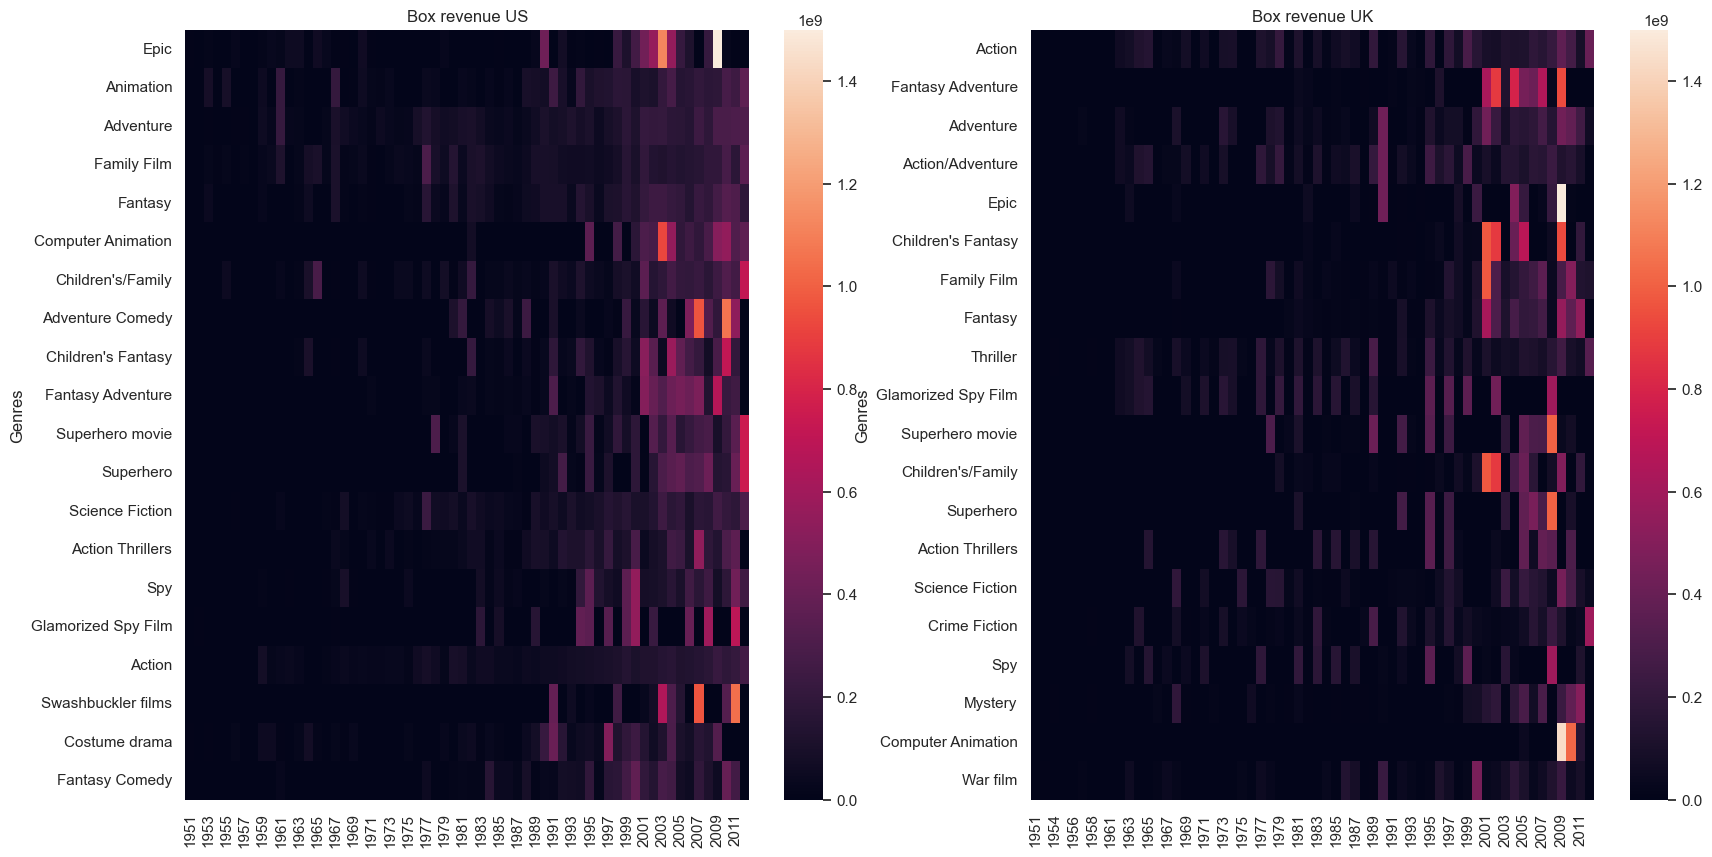

In [ ]:
# Box revenue of genres vs release date for the US
exploded = pruned[pruned["Countries"].apply(lambda x: x =="United States of America" )].explode("Genres")
tmp = exploded.pivot_table(index = 'Genres', columns='Release', values='BoxRevenue', aggfunc='mean', fill_value=0)
d = tmp.apply(lambda x: sum(x), axis = 1)
d.name = 'tmp'
tmp = pd.concat([tmp, d], axis=1).nlargest(20, 'tmp').drop('tmp', axis=1)
tmp = tmp.loc[:, tmp.apply(lambda x: int(x.name)>1950, axis = 0)]
# Box revenue of genres vs release date for the UK
exploded = pruned[pruned["Countries"].apply(lambda x: x =="United Kingdom" )].explode("Genres")
temp = exploded[exploded["Release"].notna()]
temp = temp[temp["Release"].astype(float)>1950].pivot_table(index = 'Genres', columns='Release', values='BoxRevenue', aggfunc='mean', fill_value=0)
d = temp.apply(lambda x: sum(x), axis = 1)
d.name = 'temp'
temp = pd.concat([temp, d], axis=1).nlargest(20, "temp").drop('temp', axis=1)
# The max values has been fixed at 1.5e9
f,(ax1,ax2) = plt.subplots(1,2, figsize=(20, 10))
ax1 = sns.heatmap(tmp, ax = ax1, vmax=1.5e9)
ax1.set_title("Box revenue US")
ax2 = sns.heatmap(temp, ax=ax2, vmax=1.5e9)
ax2.set_title("Box revenue UK")


<AxesSubplot: xlabel='Release', ylabel='Countries'>

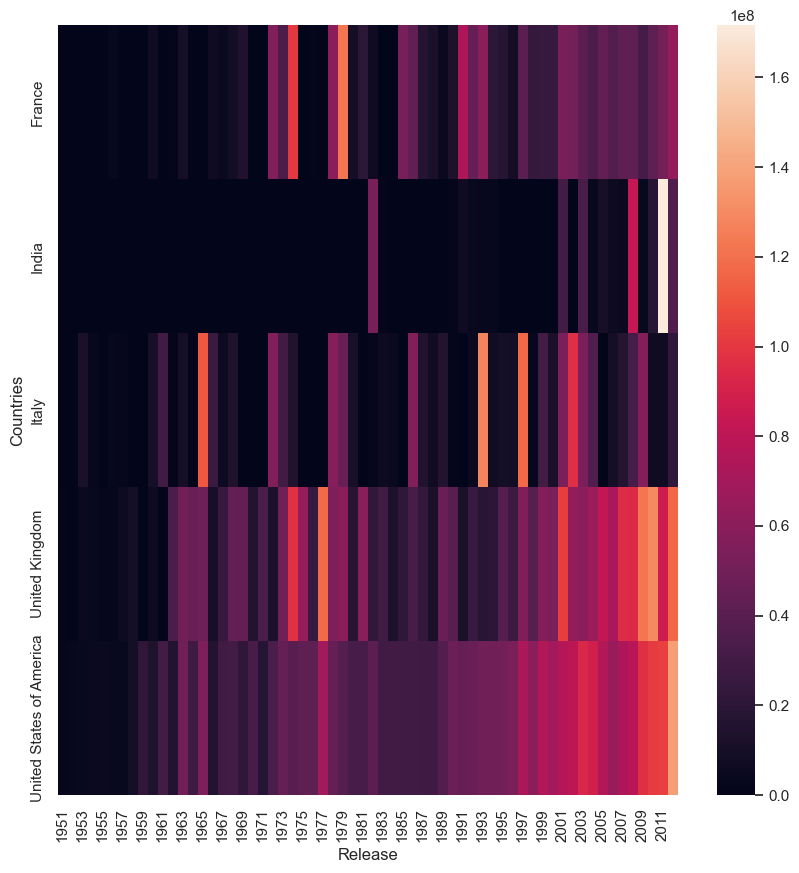

In [ ]:
# What are the most common genres for the 5 top producing countries
temp = processed[pruned["Release"].notna()]
temp = temp[temp["Release"].astype(float)>1950].pivot_table(index = 'Countries', columns='Release', values='BoxRevenue', aggfunc='mean', fill_value=0)
sns.heatmap(temp)

<AxesSubplot: ylabel='Genres'>

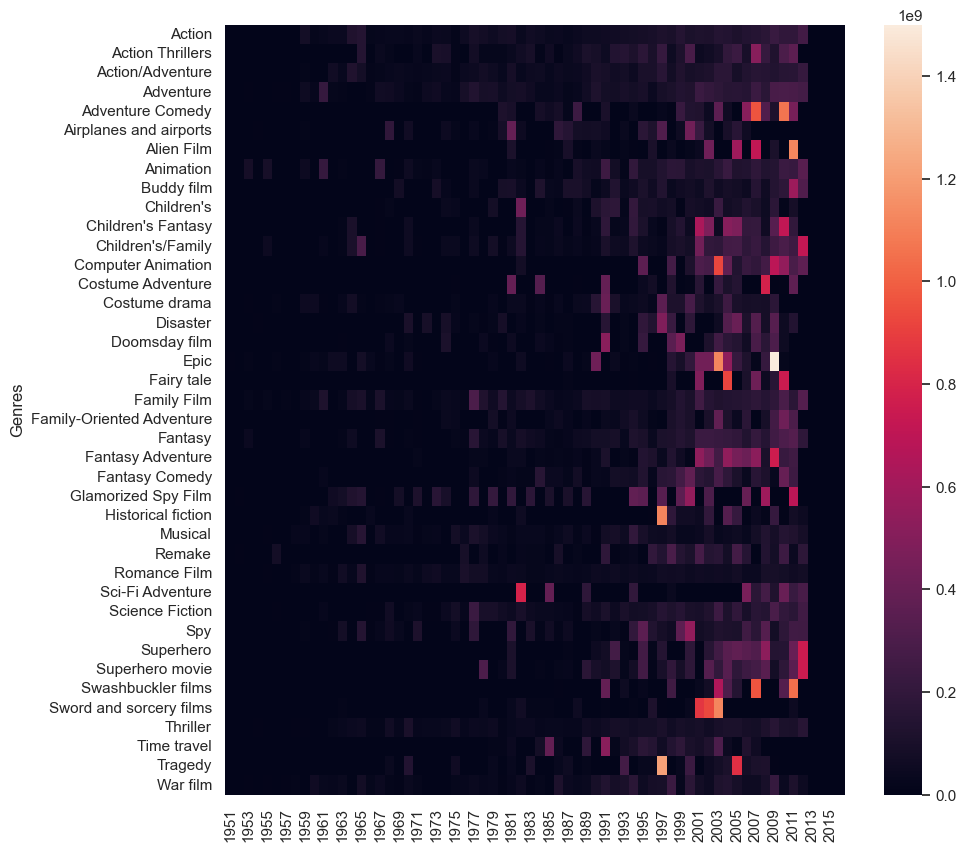

In [ ]:
# BoxRevenue globally
exploded = pruned.explode("Genres")
tmp = exploded.pivot_table(index = 'Genres', columns='Release', values='BoxRevenue', aggfunc='mean', fill_value=0, dropna=False)
d = tmp.apply(lambda x: x.sum(skipna=True), axis = 1)
d.name = 'tmp'
tmp = pd.concat([tmp, d], axis=1).nlargest(40, 'tmp').drop('tmp', axis=1)
tmp = tmp.loc[:, tmp.apply(lambda x: int(x.name)>1950, axis = 0)]
tmp = tmp.sort_index()
# The max value has been fixed at 1.5e9 for better visualization
sns.heatmap(tmp, vmax=1.5e9)

C:\Users\nico9\AppData\Local\Temp\ipykernel_13324\2841675088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pepe["Release"] = pepe["Release"].astype(float)
C:\Users\nico9\AppData\Local\Temp\ipykernel_13324\2841675088.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pepe = pepe[pepe["Release"]>1913][pepe["Release"]<2013]


<AxesSubplot: xlabel='Release', ylabel='Count'>

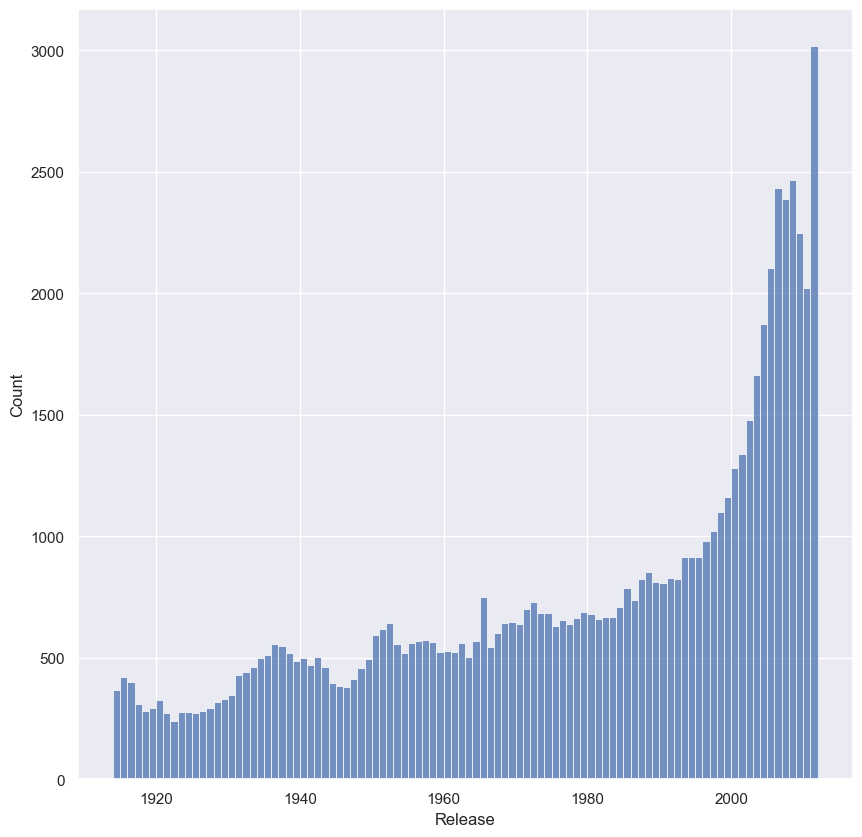

In [ ]:
pepe = movie_metadata[movie_metadata["Release"].notna()]
pepe["Release"] = pepe["Release"].astype(float)
pepe = pepe[pepe["Release"]>1913][pepe["Release"]<2013]
sns.histplot(data=pepe, x="Release", bins=98)
